In [22]:
# ----------------------------------------------------------------------------
# Read data from Spark Thrift Server
# ----------------------------------------------------------------------------

import pandas as pd
from pyhive import hive

# Connect to Spark Thrift Server
host = "spark-thrift"
port = 10000
username = "spark"
database = "default"
table = "dbt_gold_eta_features"

conn = hive.Connection(
    host=host,
    port=port,
    username=username,
    database=database
)

query = f"SELECT * FROM {table}"
df = pd.read_sql(query, conn)
conn.close()

print("===== RAW DATA SAMPLE =====")
display(df.head())

/tmp/ipykernel_16/1540159689.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


===== RAW DATA SAMPLE =====


,start_date,trip_id,current_stop_sequence,arrival_time,departure_time,next_arrival_time,travel_time_second,producer_timestamp_ts
0,20250220,101561H0,7,2025-02-20 08:21:32,2025-02-20 08:21:32,2025-02-20 08:22:29,57.0,2025-02-20 08:22:16
1,20250220,101561H0,8,2025-02-20 08:22:29,2025-02-20 08:23:30,2025-02-20 08:24:31,122.0,2025-02-20 08:24:16
2,20250220,101561H0,9,2025-02-20 08:24:31,2025-02-20 08:25:32,2025-02-20 08:26:32,121.0,2025-02-20 08:26:16
3,20250220,101561H0,10,2025-02-20 08:26:32,2025-02-20 08:27:29,2025-02-20 08:28:30,118.0,2025-02-20 08:28:16
4,20250220,101561H0,11,2025-02-20 08:28:30,2025-02-20 08:28:30,2025-02-20 08:29:31,61.0,2025-02-20 08:29:16


In [23]:
# ----------------------------------------------------------------------------
# Data Cleaning
# ----------------------------------------------------------------------------

import pandas as pd

# 1) Calculate the maximum `current_stop_sequence` for each `start_date` and `trip_id`
max_seq = (
    df.groupby(["start_date", "trip_id"])["current_stop_sequence"]
    .max()
    .reset_index(name="max_seq")
)

# 2) Merge the `max_seq` DataFrame with the original df
df_merged = df.merge(max_seq, on=["start_date", "trip_id"], how="left")

# 3) Conditions to remove:
#    (a) `current_stop_sequence` = max_seq AND `next_arrival_time` is null
#    (b) `travel_time_second` < 0
cond_end_null = (
    (df_merged["current_stop_sequence"] == df_merged["max_seq"]) &
    df_merged["next_arrival_time"].isnull()
)
cond_negative = (df_merged["travel_time_second"] < 0)
cond_remove = cond_end_null | cond_negative

print("Rows to remove:", df_merged[cond_remove].shape[0])

# 4) Exclude those rows and drop `max_seq`
df_filtered = df_merged[~cond_remove].copy()
df_filtered.drop(columns=["max_seq"], inplace=True)
print("After cleaning, df_filtered shape:", df_filtered.shape)

# Overwrite original df with cleaned version
df = df_filtered

display(df.head())

Rows to remove: 4083
After cleaning, df_filtered shape: (67997, 8)


,start_date,trip_id,current_stop_sequence,arrival_time,departure_time,next_arrival_time,travel_time_second,producer_timestamp_ts
0,20250220,101561H0,7,2025-02-20 08:21:32,2025-02-20 08:21:32,2025-02-20 08:22:29,57.0,2025-02-20 08:22:16
1,20250220,101561H0,8,2025-02-20 08:22:29,2025-02-20 08:23:30,2025-02-20 08:24:31,122.0,2025-02-20 08:24:16
2,20250220,101561H0,9,2025-02-20 08:24:31,2025-02-20 08:25:32,2025-02-20 08:26:32,121.0,2025-02-20 08:26:16
3,20250220,101561H0,10,2025-02-20 08:26:32,2025-02-20 08:27:29,2025-02-20 08:28:30,118.0,2025-02-20 08:28:16
4,20250220,101561H0,11,2025-02-20 08:28:30,2025-02-20 08:28:30,2025-02-20 08:29:31,61.0,2025-02-20 08:29:16


In [24]:
# ----------------------------------------------------------------------------
# Data Profiling
# ----------------------------------------------------------------------------

print("===== df.info() =====")
df.info()

print("\n===== df.describe() =====")
display(df.describe(include='all', datetime_is_numeric=True))

# Advanced data exploration with ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="ETA Dataset Profiling")
profile.to_notebook_iframe()


===== df.info() =====
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67997 entries, 0 to 72078
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   start_date             67997 non-null  object        
 1   trip_id                67997 non-null  object        
 2   current_stop_sequence  67997 non-null  int64         
 3   arrival_time           67997 non-null  datetime64[ns]
 4   departure_time         67997 non-null  datetime64[ns]
 5   next_arrival_time      67997 non-null  datetime64[ns]
 6   travel_time_second     67997 non-null  float64       
 7   producer_timestamp_ts  67997 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(2)
memory usage: 4.7+ MB

===== df.describe() =====


,start_date,trip_id,current_stop_sequence,arrival_time,departure_time,next_arrival_time,travel_time_second,producer_timestamp_ts
count,67997,67997,67997.000000,67997,67997,67997,67997.000000,67997
unique,5,3398,NaN,NaN,NaN,NaN,NaN,NaN
top,20250221,431418A0,NaN,NaN,NaN,NaN,NaN,NaN
freq,31859,76,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,13.779049,2025-02-22 09:41:08.284718336,2025-02-22 09:42:16.342647808,2025-02-22 09:43:22.400856064,134.116137,2025-02-22 09:43:00.114137600
min,NaN,NaN,1.000000,2025-02-20 08:21:04,2025-02-20 08:21:04,2025-02-20 08:22:05,28.000000,2025-02-20 08:22:16
25%,NaN,NaN,6.000000,2025-02-21 03:58:34,2025-02-21 04:00:03,2025-02-21 04:01:06,117.000000,2025-02-21 04:01:15
50%,NaN,NaN,12.000000,2025-02-21 11:00:34,2025-02-21 11:02:01,2025-02-21 11:03:29,121.000000,2025-02-21 11:02:50
75%,NaN,NaN,19.000000,2025-02-23 12:39:03,2025-02-23 12:40:34,2025-02-23 12:41:35,150.000000,2025-02-23 12:41:33
max,NaN,NaN,38.000000,2025-02-24 07:27:34,2025-02-24 07:27:34,2025-02-24 07:28:35,5070.000000,2025-02-24 07:28:04


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
# ----------------------------------------------------------------------------
# Remove Outliers
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd

# 1) calculate the IQR (Interquartile Range)
Q1 = df["travel_time_second"].quantile(0.25)
Q3 = df["travel_time_second"].quantile(0.75)
IQR = Q3 - Q1

# 2) see records outside the IQR range (outliers)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3) Remove outliers
df_no_outlier = df[
    (df["travel_time_second"] >= lower_bound) & 
    (df["travel_time_second"] <= upper_bound)
].copy()

print("Before outlier removal:", len(df))
print("After outlier removal:", len(df_no_outlier))

# 4) use df_no_outlier for further analysis 
df = df_no_outlier


Before outlier removal: 67997
After outlier removal: 54876


In [68]:
# ----------------------------------------------------------------------------
# Feature Engineering
# ----------------------------------------------------------------------------

import pandas as pd

# Convert columns to proper dtypes if needed
df["arrival_time"] = pd.to_datetime(df["arrival_time"])
df["departure_time"] = pd.to_datetime(df["departure_time"])
df["next_arrival_time"] = pd.to_datetime(df["next_arrival_time"])
df["producer_timestamp_ts"] = pd.to_datetime(df["producer_timestamp_ts"])

df["travel_time_second"] = df["travel_time_second"].astype(float)
df["current_stop_sequence"] = df["current_stop_sequence"].astype(int)

# Create day_of_week, hour_of_day
df["day_of_week"] = df["arrival_time"].dt.weekday  # 0=Monday,6=Sunday
df["hour_of_day"] = df["arrival_time"].dt.hour

print("===== After Feature Engineering =====")
display(df.head())


===== After Feature Engineering =====


,start_date,trip_id,current_stop_sequence,arrival_time,departure_time,next_arrival_time,travel_time_second,producer_timestamp_ts,day_of_week,hour_of_day,baseline_pred,trip_id_encoded
1,20250220,101561H0,8,2025-02-20 08:22:29,2025-02-20 08:23:30,2025-02-20 08:24:31,122.0,2025-02-20 08:24:16,3,8,122.0,150
2,20250220,101561H0,9,2025-02-20 08:24:31,2025-02-20 08:25:32,2025-02-20 08:26:32,121.0,2025-02-20 08:26:16,3,8,121.0,150
3,20250220,101561H0,10,2025-02-20 08:26:32,2025-02-20 08:27:29,2025-02-20 08:28:30,118.0,2025-02-20 08:28:16,3,8,118.0,150
5,20250220,101561H0,12,2025-02-20 08:29:31,2025-02-20 08:30:32,2025-02-20 08:31:32,121.0,2025-02-20 08:31:16,3,8,121.0,150
8,20250220,101577H0,1,2025-02-20 08:21:32,2025-02-20 08:22:29,2025-02-20 08:23:30,118.0,2025-02-20 08:23:16,3,8,118.0,156


In [69]:
# ----------------------------------------------------------------------------
# Split train/test data
# ----------------------------------------------------------------------------

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df["trip_id_encoded"] = le.fit_transform(df["trip_id"])

feature_cols = ["trip_id_encoded", "current_stop_sequence", "day_of_week", "hour_of_day"]
X = df[feature_cols].copy()  # features
y = df["travel_time_second"].copy()  # target

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [70]:
# ----------------------------------------------------------------------------
# Build Baseline Model
# ----------------------------------------------------------------------------

# consolidate the train data
train_data = X_train.copy()
train_data["travel_time_second"] = y_train

# group by (trip_id, current_stop_sequence, day_of_week, hour_of_day)
group_cols = ["trip_id_encoded", "current_stop_sequence", "day_of_week", "hour_of_day"]

# calculate the mean travel time for each group (trip_id, current_stop_sequence, day_of_week, hour_of_day)
baseline_means = train_data.groupby(group_cols)["travel_time_second"].mean()

# overall mean travel time for fallback
global_mean = train_data["travel_time_second"].mean()

print("Number of baseline groups:", len(baseline_means))
print("Global mean (fallback):", global_mean)

Number of baseline groups: 43900
Global mean (fallback): 130.75086560364466


In [71]:
# ----------------------------------------------------------------------------
# Predict and Evaluate with Baseline Model
# ----------------------------------------------------------------------------

# there are (trip_id, current_stop_sequence, day_of_week, hour_of_day) in test data
test_data = X_test.copy()

def baseline_predict(row):
    key = (
        row["trip_id_encoded"],
        row["current_stop_sequence"],
        row["day_of_week"],
        row["hour_of_day"]
    )
    if key in baseline_means:
        return baseline_means[key]
    else:
        # fallback to global mean
        return global_mean

# create a new column "baseline_pred" in test_data
test_data["baseline_pred"] = test_data.apply(baseline_predict, axis=1)

# compare with actual travel time
mae_base = mean_absolute_error(y_test, test_data["baseline_pred"])
rmse_base = mean_squared_error(y_test, test_data["baseline_pred"], squared=False)

print("===== Baseline Model (Train→Test) =====")
print(f"MAE : {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")


===== Baseline Model (Train→Test) =====
MAE : 21.91
RMSE: 26.64


In [72]:
# ----------------------------------------------------------------------------
# Build Regression Model
# ----------------------------------------------------------------------------

from xgboost import XGBRegressor

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("===== Regression Model Results =====")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")


===== Regression Model Results =====
MAE : 17.573
RMSE: 23.190
R^2 : 0.242


In [73]:
# ----------------------------------------------------------------------------
# Validate Predictions
# ----------------------------------------------------------------------------

print("=== Compare Baseline vs Regression ===")
print(f"Baseline  - MAE={mae_base:.2f}, RMSE={rmse_base:.2f}")
print(f"XGBoost   - MAE={mae:.2f},  RMSE={rmse:.2f}, R^2={r2:.2f}")

=== Compare Baseline vs Regression ===
Baseline  - MAE=21.91, RMSE=26.64
XGBoost   - MAE=17.57,  RMSE=23.19, R^2=0.24


In [74]:
print("len(X_test)=", len(X_test))
print("len(errors)=", len(errors))
print(errors.head(10))

len(X_test)= 10976
len(errors)= 13600
52008    12.505875
31767   -29.947876
38641    48.330917
13430    25.490265
5913     55.608505
59260    -9.741463
43277     8.981392
57745    29.009338
23782   -57.089447
57306   -69.514374
Name: travel_time_second, dtype: float64


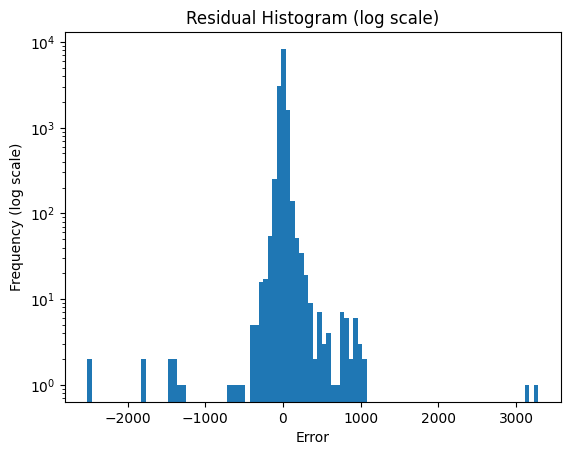

In [64]:
errors = y_test - y_pred   # residuals
abs_errors = abs(errors)   # absolute residuals

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(errors, bins=100, log=True)
plt.title("Residual Histogram (log scale)")
plt.xlabel("Error")
plt.ylabel("Frequency (log scale)")
plt.show()

plt.show()